<a href="https://colab.research.google.com/github/sathwikreddykatla/tutorial/blob/master/ml3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0: Loss: 0.2656012177467346
Epoch 30: Loss: 0.22896528244018555
Epoch 60: Loss: 0.20527544617652893
Epoch 90: Loss: 0.17485754191875458
Epoch 120: Loss: 0.14020270109176636
Epoch 150: Loss: 0.10596528649330139
Epoch 180: Loss: 0.07557028532028198
Epoch 210: Loss: 0.051293037831783295
Epoch 240: Loss: 0.03272981941699982
Epoch 270: Loss: 0.019146841019392014
Epoch 300: Loss: 0.009913284331560135
Epoch 330: Loss: 0.004496759735047817
Epoch 360: Loss: 0.0017612171359360218
Epoch 390: Loss: 0.0005840315716341138
Epoch 420: Loss: 0.00016457638412248343
Epoch 450: Loss: 3.996394661953673e-05
Epoch 480: Loss: 8.952377356763463e-06


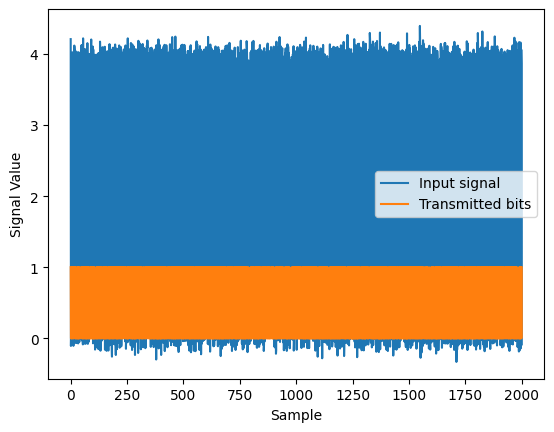

In [1]:
import numpy as np
import tensorflow as tf
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

# Constants and hyperparameters
learning_rate = 0.001
batch_size = 200
epochs = 500
c1 = np.sqrt(16)  # power allocation factor
c2 = np.sqrt(4)   # power allocation factor

# Quantization function
def quantized(y, q_levels, q_range):
    delta = 2 * q_range / q_levels
    value_max = q_range - delta / 2
    y_quantized = delta * np.floor((y + q_range) / delta) - value_max
    y_quantized[np.where(y_quantized > value_max)] = value_max
    y_quantized[np.where(y_quantized < -value_max)] = -value_max
    return y_quantized

# Build model with Keras Sequential API for simplicity
def build_decoder_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

decoder1 = build_decoder_model()
decoder2 = build_decoder_model()
decoder3 = build_decoder_model()

# Example function to generate data
def generate_data(block_size, noise_std, h):
    coded_bits3 = np.random.binomial(n=1, p=0.5, size=(block_size, 1))  # example binary data
    x = coded_bits3 * c1  # transmitted signal with coding
    noise = noise_std * np.random.normal(0, 1, x.shape)
    y = h * x + noise
    y_reshaped = np.reshape(y, (len(y), 1))
    return y_reshaped, coded_bits3

# Training function using GradientTape for each model
# Training function using GradientTape for each model
def train_model(model, y_data, s3_data):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            pred = model(y_data, training=True)
            loss = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(s3_data, pred))
        grads = tape.gradient(loss, model.trainable_variables)
        tf.optimizers.Adam(learning_rate).apply_gradients(zip(grads, model.trainable_variables))
        if epoch % 30 == 0:
            print(f"Epoch {epoch}: Loss: {loss.numpy()}")

# Generate sample data and train model
h = 1  # Assuming a static channel
block_size = 2000
noise_std = 0.1
y_data, s3_data = generate_data(block_size, noise_std, h)
train_model(decoder1, y_data, s3_data)

# Plotting (sample)
plt.plot(y_data, label='Input signal')
plt.plot(s3_data, label='Transmitted bits')
plt.xlabel("Sample")
plt.ylabel("Signal Value")
plt.legend()
plt.show()


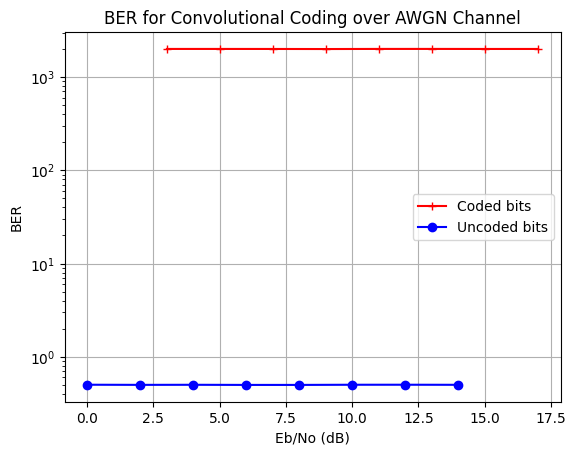

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from commpy.channelcoding.convcode import Trellis
from commpy.channelcoding import viterbi_decode, conv_encode

# Define convolutional coding parameters
generator_matrix = np.array([[5, 7]])  # In octal: '101', '111'
trellis = Trellis(np.array([2]), generator_matrix)  # Constraint length = 3

# Channel and simulation parameters
EbNodB = list(np.linspace(0, 14, 8))
num_blocks = 100
block_size = 2000
code_rate = 1 / 2

# Hyperparameters
learning_rate = 0.001
batch_size = 200
epochs = 300
act_func = tf.nn.relu

# Model definition using Keras
class DecoderModel(tf.keras.Model):
    def __init__(self, layers):
        super(DecoderModel, self).__init__()
        self.dense_layers = [tf.keras.layers.Dense(units, activation=act_func) for units in layers]

    def call(self, x):
        for layer in self.dense_layers:
            x = layer(x)
        return x

# Define models
decoder1 = DecoderModel([16, 8, 1])
decoder2 = DecoderModel([24, 12, 1])
decoder3 = DecoderModel([32, 16, 1])

# Data generation and decoding functions
def generate_data(block_size, noise_std, h):
    uncoded_bits = np.random.randint(0, 2, block_size)
    coded_bits = conv_encode(uncoded_bits, trellis)  # Use the Trellis object for encoding
    x = 2 * coded_bits - 1
    noise = noise_std * np.random.normal(0, 1, x.shape)
    y = h * x + noise
    return np.reshape(y, (-1, 1)), np.reshape(coded_bits, (-1, 1)), uncoded_bits

def decode_bits(y_, decoder1, decoder2, decoder3):
    p1 = decoder1(y_)
    z2 = tf.concat([y_, p1], axis=-1)
    p2 = decoder2(z2)
    z3 = tf.concat([z2, p2], axis=-1)
    p3 = decoder3(z3)
    return p3

# Simulation
ber_coded, ber_uncoded = [], []

for EbNo_dB in EbNodB:
    EbNo = 10 ** (EbNo_dB / 10.0)
    noise_std = np.sqrt(1 / (2 * code_rate * EbNo))

    num_errors_coded, num_errors_uncoded = 0, 0
    coded_bit_count, uncoded_bit_count = 0, 0

    for block in range(num_blocks):
        y_, coded_bits, uncoded_bits = generate_data(block_size, noise_std, h=1)
        y_tensor = tf.convert_to_tensor(y_, dtype=tf.float32)

        # Decode
        p3 = decode_bits(y_tensor, decoder1, decoder2, decoder3)
        s_re = tf.sign(p3.numpy().flatten() - 0.5)

        # Use tf.round and convert to int
        decoded_bits = tf.round((s_re + 1) / 2).numpy().astype(int)
        uncoded_bits_re = viterbi_decode(decoded_bits, trellis, tb_depth=5)

        uncoded_bit_count += len(uncoded_bits)
        coded_bit_count += len(coded_bits)
        num_errors_uncoded += np.sum(uncoded_bits != uncoded_bits_re[:len(uncoded_bits)])
        num_errors_coded += np.sum(coded_bits != decoded_bits[:len(coded_bits)])

    ber_coded.append(num_errors_coded / coded_bit_count)
    ber_uncoded.append(num_errors_uncoded / uncoded_bit_count)

# Plot results
EbNodB_coded = list(np.asarray(EbNodB) - 10 * np.log10(code_rate))
plt.plot(EbNodB_coded, ber_coded, '-r+', label='Coded bits')
plt.plot(EbNodB, ber_uncoded, '-bo', label='Uncoded bits')
plt.yscale('log')
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.title('BER for Convolutional Coding over AWGN Channel')
plt.legend()
plt.grid()
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import levy_stable

# Modulation parameters
M = 4  # M-ary modulation size (QPSK)
K = 3  # Number of users
m = int(np.log2(M))

# Training parameters
epsilon = 0.01  # CSI error variance
EbNodB = list(np.linspace(0, 15, 6))
num_symbols_train = 5000
num_symbols_test = 400000
noise_type = 'awgn'  # Other options: 't-dist', 'stable-dist', 'radar'

# Noise parameters
vv = 5  # t-distribution scale
radar_prob = 0.05
radar_power_factor = 4
alpha, beta = 1.8, -0.5

# Network parameters
snr_train_db = 8
learning_rate = 0.001
batch_size = 200
epochs = 250
activation_function = tf.nn.relu

# Power allocation factors and channel
c1, c2 = np.sqrt(16), np.sqrt(4)
h = (1 + 1j) / np.sqrt(2)

# Quantization parameters
q_levels, q_range = 8, 8

# Quantization function
def quantized(y, q_levels, q_range):
    delta = 2 * q_range / q_levels
    value_max = q_range - delta / 2
    y_quantized = delta * np.floor((y + q_range) / delta) - value_max
    y_quantized = np.clip(y_quantized, -value_max, value_max)
    return y_quantized

# Neural network model with 3 decoders
def build_decoder(units, M):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation=activation_function),
        tf.keras.layers.Dense(units // 2, activation=activation_function),
        tf.keras.layers.Dense(M, activation='softmax')
    ])

decoder1 = build_decoder(24, M)
decoder2 = build_decoder(32, M)
decoder3 = build_decoder(48, M)

# Generate QAM symbols
def qam_constellation(M):
    if M == 4:
        return np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)  # QPSK
    elif M == 8:
        return np.array([1, (1+1j)/np.sqrt(2), (-1+1j)/np.sqrt(2), 1j, (1-1j)/np.sqrt(2), -1j, -1, (-1-1j)/np.sqrt(2)])
    elif M == 16:
        return np.array([-3+3j, -3+1j, -3-3j, -3-1j, -1+3j, -1+1j, -1-3j, -1-1j,
                         3+3j, 3+1j, 3-3j, 3-1j, 1+3j, 1+1j, 1-3j, 1-1j])
    elif M == 2:
        return np.array([-1, 1])  # BPSK
    else:
        raise ValueError('Modulation order must be in {2,4,8,16}.')

# Generate training data
def generate_data_qam_symbols(M=4, N=16, num_samples=5):
    m = int(np.log2(M))
    QAM = qam_constellation(M)
    bits = np.random.binomial(n=1, p=0.5, size=(num_samples, N, m))
    sym_one_hot = np.zeros((num_samples, N, M), dtype=int)
    sym_com = np.zeros((num_samples, N), dtype=complex)
    for i in range(num_samples):
        bit = bits[i]
        sym = np.zeros((N,), dtype=complex)
        for j in range(N):
            sym_id = bit[j].dot(2 ** np.arange(bit[j].size)[::-1])
            sym[j] = QAM[sym_id]
            sym_one_hot[i, j, sym_id] = 1
        sym_com[i] = sym
    return bits, sym_com, sym_one_hot

# Generate full data including noise
def generate_data(M, K, noise_std, h, num_symbols):
    bits, sym_com, sym_one_hot = generate_data_qam_symbols(M=M, N=K, num_samples=num_symbols)
    x1, x2, x3 = sym_com[:, 0], sym_com[:, 1], sym_com[:, 2]
    x = x3 + c2 * x2 + c1 * x1

    if noise_type == 'awgn':
        noise = noise_std * (np.random.normal(0, 1, x.shape) + 1j * np.random.normal(0, 1, x.shape))
    elif noise_type == 't-dist':
        noise = noise_std * np.sqrt((vv - 2) / vv) * np.random.standard_t(vv, size=x.shape)
    elif noise_type == 'radar':
        add_pos = np.random.choice([0.0, 1.0], x.shape, p=[1 - radar_prob, radar_prob])
        corrupted_signal = radar_power_factor * np.random.standard_normal(size=x.shape) * add_pos
        noise = noise_std * (np.random.normal(0, 1, x.shape) + corrupted_signal)
    elif noise_type == 'stable-dist':
        noise = noise_std * levy_stable.rvs(alpha, beta, size=x.shape)

    y = h * x + noise
    y_ = np.stack([np.real(y), np.imag(y)], axis=1)
    return y_, sym_one_hot[:, 0, :], sym_one_hot[:, 1, :], sym_one_hot[:, 2, :]

# Training loop
optimizer = tf.keras.optimizers.Adam(learning_rate)
cce = tf.keras.losses.CategoricalCrossentropy()
ber_coded, ser = [None] * len(EbNodB), [None] * len(EbNodB)

for epoch in range(epochs):
    y_train, s1_train, s2_train, s3_train = generate_data(M, K, noise_std=0.1, h=h, num_symbols=num_symbols_train)
    dataset = tf.data.Dataset.from_tensor_slices((y_train, s1_train, s2_train, s3_train)).batch(batch_size)

    for batch, (y_batch, s1_batch, s2_batch, s3_batch) in enumerate(dataset):
        with tf.GradientTape() as tape:
            p1 = decoder1(y_batch)
            z2 = tf.concat([y_batch, p1], axis=-1)
            p2 = decoder2(z2)
            z3 = tf.concat([z2, p2], axis=-1)
            p3 = decoder3(z3)
            loss = cce(s1_batch, p1) + cce(s2_batch, p2) + cce(s3_batch, p3)
        gradients = tape.gradient(loss, decoder1.trainable_variables + decoder2.trainable_variables + decoder3.trainable_variables)
        optimizer.apply_gradients(zip(gradients, decoder1.trainable_variables + decoder2.trainable_variables + decoder3.trainable_variables))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Testing and plotting
EbNo_vals, ser_vals = [], []
for EbNo_db in EbNodB:
    noise_std = np.sqrt(1 / (10 ** (EbNo_db / 10)) / 2)
    y_test, _, _, s3_test = generate_data(M, K, noise_std, h, num_symbols_test)

    # Forward pass through decoders
    p1_test = decoder1(y_test)
    z2_test = tf.concat([y_test, p1_test], axis=-1)
    p2_test = decoder2(z2_test)
    z3_test = tf.concat([z2_test, p2_test], axis=-1)
    p3_test = decoder3(z3_test)

    # Calculate SER
    s3_dec, s3_est = tf.argmax(s3_test, axis=1), tf.argmax(p3_test, axis=1)
    ser_curr = tf.reduce_mean(tf.cast(s3_dec != s3_est, tf.float32)).numpy()
    ser_vals.append(ser_curr)
    EbNo_vals.append(EbNo_db)
    print(f"SER for EbNo={EbNo_db} dB: {ser_curr}")

# Plotting results
plt.plot(EbNo_vals, ser_vals, '-bo', label='Uncoded bits')
plt.yscale('log')
plt.xlabel('EbNo (dB)')
plt.ylabel('SER')
plt.title(f'NOMA 3 users under channel, noise type: {noise_type}')
plt.grid()
plt.show()


InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:ConcatV2] name: concat

Epoch 0, Loss: 3.690981388092041
Epoch 10, Loss: 1.8366209268569946
Epoch 20, Loss: 0.889037013053894
Epoch 30, Loss: 0.12747058272361755
Epoch 40, Loss: 0.03911661356687546
Epoch 50, Loss: 0.016781272366642952
Epoch 60, Loss: 0.012690426781773567
Epoch 70, Loss: 0.007684479467570782
Epoch 80, Loss: 0.00596334645524621
Epoch 90, Loss: 0.0042963274754583836
Epoch 100, Loss: 0.0029871747829020023
Epoch 110, Loss: 0.0025992707815021276
Epoch 120, Loss: 0.0016967316623777151
Epoch 130, Loss: 0.0017566352616995573
Epoch 140, Loss: 0.0012594925938174129
Epoch 150, Loss: 0.00099647487513721
Epoch 160, Loss: 0.0008139945566654205
Epoch 170, Loss: 0.0007922262884676456
Epoch 180, Loss: 0.0005954295629635453
Epoch 190, Loss: 0.0005298021133057773
Epoch 200, Loss: 0.0003819722915068269
Epoch 210, Loss: 0.0003204194945283234
Epoch 220, Loss: 0.00029838387854397297
Epoch 230, Loss: 0.00030825153226032853
Epoch 240, Loss: 0.00022887650993652642
SER for EbNo=0.0 dB - User 1: 0.07815500348806381, User

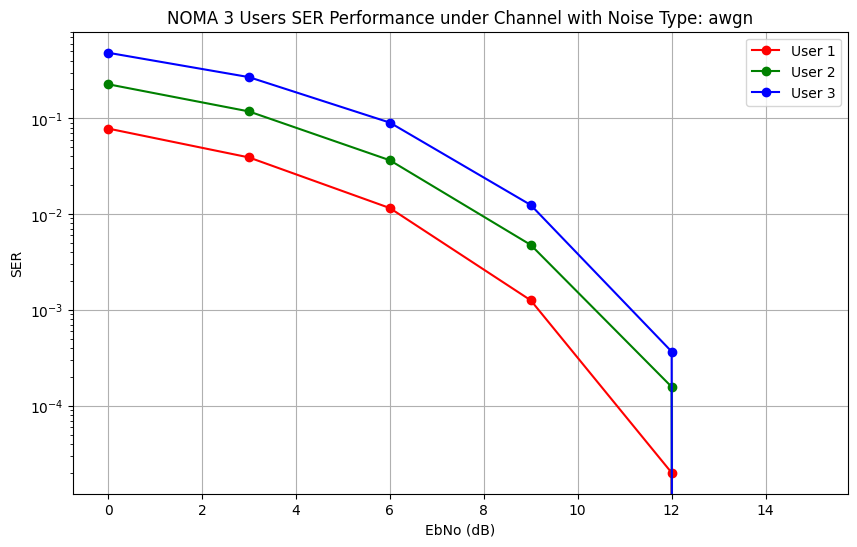

In [13]:
import numpy as np
import tensorflow as tf
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

# Modulation and training parameters
M = 4  # M-ary modulation size (QPSK)
K = 3  # Number of users
m = int(np.log2(M))
epsilon = 0.01  # CSI error variance
EbNodB = list(np.linspace(0, 15, 6))
num_symbols_train = 5000
num_symbols_test = 400000
noise_type = 'awgn'  # Other options: 't-dist', 'stable-dist', 'radar'
learning_rate = 0.001
batch_size = 200
epochs = 250
activation_function = tf.nn.relu

# Power allocation factors and channel
c1, c2 = np.sqrt(16), np.sqrt(4)
h = (1 + 1j) / np.sqrt(2)

# Define quantization function
def quantized(y, q_levels, q_range):
    delta = 2 * q_range / q_levels
    value_max = q_range - delta / 2
    y_quantized = delta * np.floor((y + q_range) / delta) - value_max
    y_quantized = np.clip(y_quantized, -value_max, value_max)
    return y_quantized

# Build a simple decoder network
def build_decoder(units, M):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation=activation_function),
        tf.keras.layers.Dense(units // 2, activation=activation_function),
        tf.keras.layers.Dense(M, activation='softmax')
    ])

decoder1 = build_decoder(24, M)
decoder2 = build_decoder(32, M)
decoder3 = build_decoder(48, M)

# Generate QAM constellation
def qam_constellation(M):
    if M == 4:
        return np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)  # QPSK
    elif M == 8:
        return np.array([1, (1+1j)/np.sqrt(2), (-1+1j)/np.sqrt(2), 1j, (1-1j)/np.sqrt(2), -1j, -1, (-1-1j)/np.sqrt(2)])
    elif M == 16:
        return np.array([-3+3j, -3+1j, -3-3j, -3-1j, -1+3j, -1+1j, -1-3j, -1-1j,
                         3+3j, 3+1j, 3-3j, 3-1j, 1+3j, 1+1j, 1-3j, 1-1j])
    elif M == 2:
        return np.array([-1, 1])  # BPSK
    else:
        raise ValueError('Modulation order must be in {2,4,8,16}.')

# Generate training data
def generate_data_qam_symbols(M=4, N=16, num_samples=5):
    m = int(np.log2(M))
    QAM = qam_constellation(M)
    bits = np.random.binomial(n=1, p=0.5, size=(num_samples, N, m))
    sym_one_hot = np.zeros((num_samples, N, M), dtype=int)
    sym_com = np.zeros((num_samples, N), dtype=complex)
    for i in range(num_samples):
        bit = bits[i]
        sym = np.zeros((N,), dtype=complex)
        for j in range(N):
            sym_id = bit[j].dot(2 ** np.arange(bit[j].size)[::-1])
            sym[j] = QAM[sym_id]
            sym_one_hot[i, j, sym_id] = 1
        sym_com[i] = sym
    return bits, sym_com, sym_one_hot

# Generate full data including noise
def generate_data(M, K, noise_std, h, num_symbols):
    bits, sym_com, sym_one_hot = generate_data_qam_symbols(M=M, N=K, num_samples=num_symbols)
    x1, x2, x3 = sym_com[:, 0], sym_com[:, 1], sym_com[:, 2]
    x = x3 + c2 * x2 + c1 * x1

    if noise_type == 'awgn':
        noise = noise_std * (np.random.normal(0, 1, x.shape) + 1j * np.random.normal(0, 1, x.shape))
    elif noise_type == 't-dist':
        noise = noise_std * np.sqrt((vv - 2) / vv) * np.random.standard_t(vv, size=x.shape)
    elif noise_type == 'radar':
        add_pos = np.random.choice([0.0, 1.0], x.shape, p=[1 - radar_prob, radar_prob])
        corrupted_signal = radar_power_factor * np.random.standard_normal(size=x.shape) * add_pos
        noise = noise_std * (np.random.normal(0, 1, x.shape) + corrupted_signal)
    elif noise_type == 'stable-dist':
        noise = noise_std * levy_stable.rvs(alpha, beta, size=x.shape)

    y = h * x + noise
    y_ = np.stack([np.real(y), np.imag(y)], axis=1).astype(np.float32)  # Convert to float32 here
    return y_, sym_one_hot[:, 0, :], sym_one_hot[:, 1, :], sym_one_hot[:, 2, :]

# Training loop
optimizer = tf.keras.optimizers.Adam(learning_rate)
cce = tf.keras.losses.CategoricalCrossentropy()

for epoch in range(epochs):
    y_train, s1_train, s2_train, s3_train = generate_data(M, K, noise_std=0.1, h=h, num_symbols=num_symbols_train)
    dataset = tf.data.Dataset.from_tensor_slices((y_train, s1_train, s2_train, s3_train)).batch(batch_size)

    for batch, (y_batch, s1_batch, s2_batch, s3_batch) in enumerate(dataset):
        with tf.GradientTape() as tape:
            p1 = decoder1(y_batch)
            z2 = tf.concat([y_batch, p1], axis=-1)
            p2 = decoder2(z2)
            z3 = tf.concat([z2, p2], axis=-1)
            p3 = decoder3(z3)
            loss = cce(s1_batch, p1) + cce(s2_batch, p2) + cce(s3_batch, p3)
        gradients = tape.gradient(loss, decoder1.trainable_variables + decoder2.trainable_variables + decoder3.trainable_variables)
        optimizer.apply_gradients(zip(gradients, decoder1.trainable_variables + decoder2.trainable_variables + decoder3.trainable_variables))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Testing and plotting for each user
EbNo_vals = []
ser_vals_user1, ser_vals_user2, ser_vals_user3 = [], [], []

for EbNo_db in EbNodB:
    noise_std = np.sqrt(1 / (10 ** (EbNo_db / 10)) / 2)
    y_test, s1_test, s2_test, s3_test = generate_data(M, K, noise_std, h, num_symbols_test)

    # Forward pass through decoders
    p1_test = decoder1(y_test)
    z2_test = tf.concat([y_test, p1_test], axis=-1)
    p2_test = decoder2(z2_test)
    z3_test = tf.concat([z2_test, p2_test], axis=-1)
    p3_test = decoder3(z3_test)

    # Calculate SER for each user
    s1_dec, s1_est = tf.argmax(s1_test, axis=1), tf.argmax(p1_test, axis=1)
    s2_dec, s2_est = tf.argmax(s2_test, axis=1), tf.argmax(p2_test, axis=1)
    s3_dec, s3_est = tf.argmax(s3_test, axis=1), tf.argmax(p3_test, axis=1)

    ser_user1 = tf.reduce_mean(tf.cast(s1_dec != s1_est, tf.float32)).numpy()
    ser_user2 = tf.reduce_mean(tf.cast(s2_dec != s2_est, tf.float32)).numpy()
    ser_user3 = tf.reduce_mean(tf.cast(s3_dec != s3_est, tf.float32)).numpy()

    # Append results for plotting
    EbNo_vals.append(EbNo_db)
    ser_vals_user1.append(ser_user1)
    ser_vals_user2.append(ser_user2)
    ser_vals_user3.append(ser_user3)

    print(f"SER for EbNo={EbNo_db} dB - User 1: {ser_user1}, User 2: {ser_user2}, User 3: {ser_user3}")

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(EbNo_vals, ser_vals_user1, '-ro', label='User 1')
plt.plot(EbNo_vals, ser_vals_user2, '-go', label='User 2')
plt.plot(EbNo_vals, ser_vals_user3, '-bo', label='User 3')
plt.yscale('log')
plt.xlabel('EbNo (dB)')
plt.ylabel('SER')
plt.title(f'NOMA 3 Users SER Performance under Channel with Noise Type: {noise_type}')
plt.legend()
plt.grid()
plt.show()
